In [12]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [135]:
image = cv.imread('images/1.jpg')

channels = cv.split(image)
histSize = 256
histRange = (0, 256)
accumulate = False

colors = ['b', 'g', 'r']
channels_names = ["Blue", "Green", "Red"]

### 1. Реалізація обчислення гістрограми яскравості для кольорового зображення

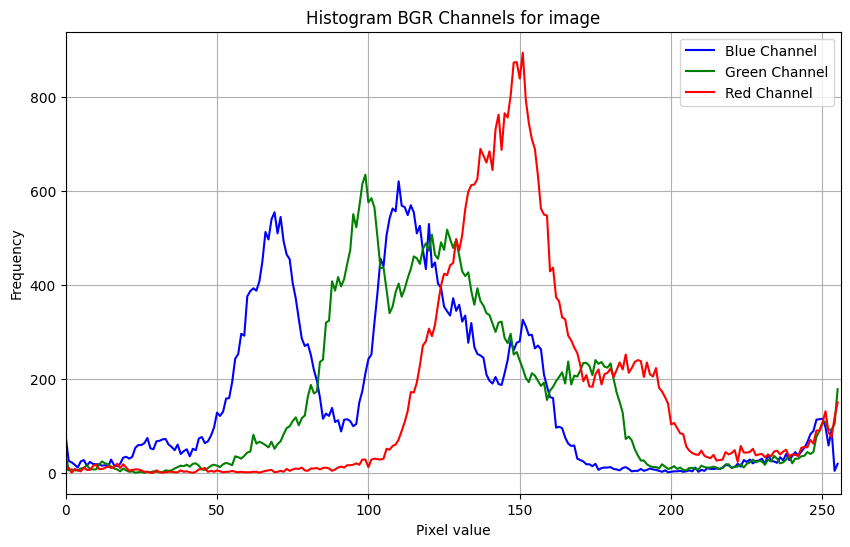

In [136]:
plt.figure(figsize=(10,6))
for i, color in enumerate(colors):
    hist = cv.calcHist([channels[i]], [0], None, [histSize], histRange, accumulate=accumulate)
    plt.plot(hist, color=color, label=f"{channels_names[i]} Channel")
    plt.xlim(histRange)

plt.title('Histogram BGR Channels for image')
plt.xlabel('Pixel value'), plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

### 2. Обчислення гістрограми для потокового відео з файлу

End of video or cannot fetch the frame.


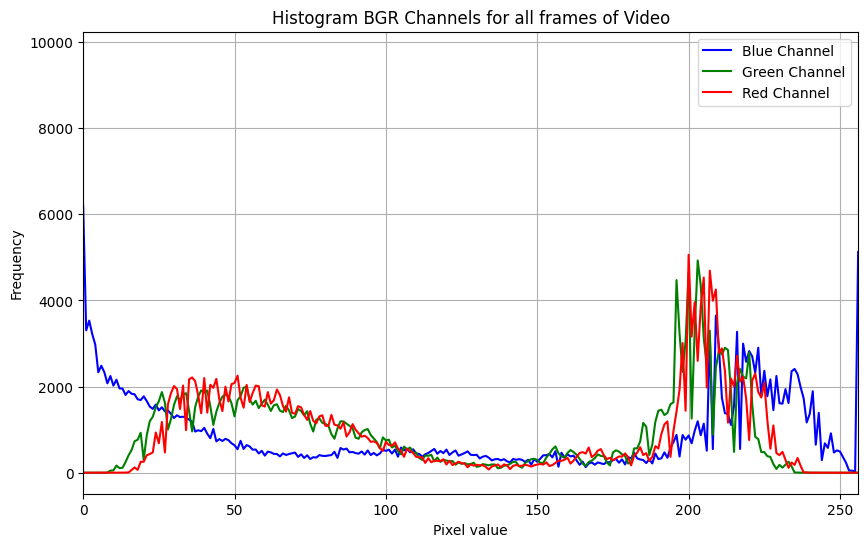

In [137]:
video_path = "videos/video.mp4"
cap = cv.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

all_sum_channels = [[] for _ in range(3)]

while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video or cannot fetch the frame.")
        break

    channels = cv.split(frame)
    for i in range(len(colors)):
        all_sum_channels[i].append(cv.calcHist([channels[i]], [0], None, [histSize], histRange, accumulate=accumulate))
        
    if cv.waitKey(0) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

plt.figure(figsize=(10,6))
for i, color in enumerate(colors):
    plt.plot(np.concatenate(all_sum_channels[i]), color=color, label=f"{channels_names[i]} Channel")
    plt.xlim(histRange)
plt.title('Histogram BGR Channels for all frames of Video')
plt.xlabel('Pixel value'), plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

### 3. Реалізація вирівнювання гістограми будь-якого зображення

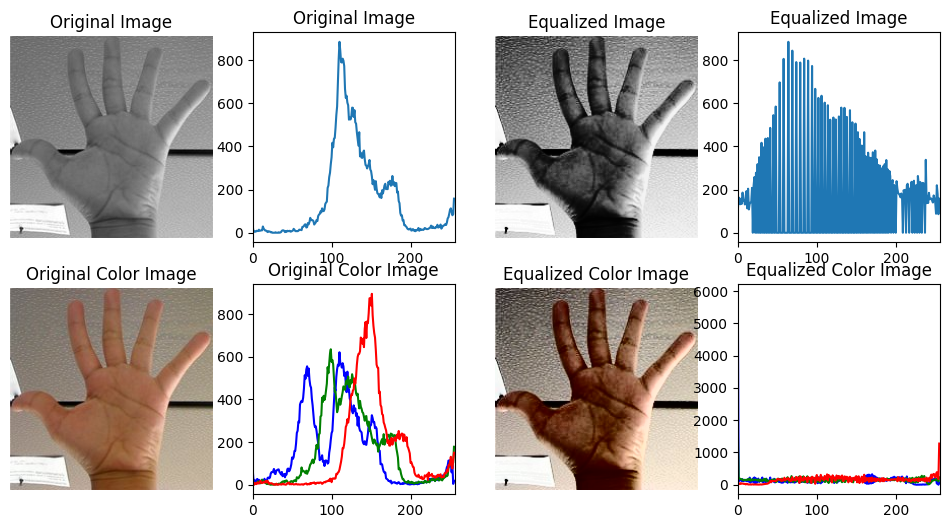

In [147]:
image_gray = cv.imread('images/1.jpg', 0)  # Load in grayscale
image_color = cv.imread('images/1.jpg')

# Apply histogram equalization for gray
equalized_image_gray = cv.equalizeHist(image_gray.copy())
hist_gray = cv.calcHist([image_gray], [0], None, [histSize], histRange, accumulate=accumulate)
hist_equalized_gray = cv.calcHist([equalized_image_gray], [0], None, [histSize], histRange, accumulate=accumulate)

yuv_image_color = cv.cvtColor(image_color, cv.COLOR_BGR2YUV)
yuv_image_color[:,:,0] = cv.equalizeHist(yuv_image_color[:,:,0])
equalized_image_color = cv.cvtColor(yuv_image_color, cv.COLOR_YUV2BGR)
hist_color = [cv.calcHist([image_color], [i], None, [histSize], histRange) for i in range(3)]
hist_equalized_color = [cv.calcHist([equalized_image_color], [i], None, [histSize], histRange) for i in range(3)]

hists = [hist_gray, hist_equalized_gray, hist_color, hist_equalized_color]
images = [image_gray, equalized_image_gray, image_color, equalized_image_color]
titles = ['Original Image', 'Equalized Image', 'Original Color Image', 'Equalized Color Image']

plt.figure(figsize=(12,6))
for i, (hist, img, title) in enumerate(zip(hists, images, titles)):
    plt.subplot(2, 4, 2*i+1)
    plt.title(title)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')


    plt.subplot(2, 4, 2*i+2)
    plt.title(title)
    if len(img.shape) == 2:
        plt.plot(hist)
    else:
        colors = ('b', 'g', 'r')
        for j, col in enumerate(colors):
            plt.plot(hist[j], color=col)
    plt.xlim([0, 256])

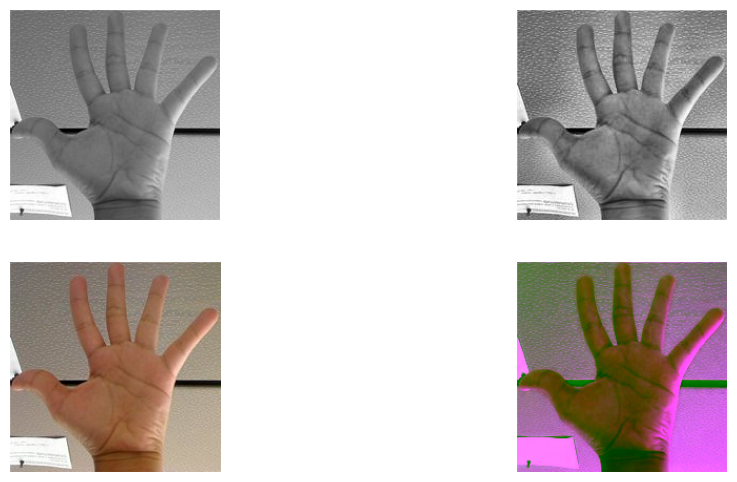

In [152]:
image_gray = cv.imread('images/1.jpg', 0)  # Load in grayscale
image_color = cv.imread('images/1.jpg')
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

cl_image_gray = clahe.apply(image_gray)

yuv_image = cv.cvtColor(image_color, cv.COLOR_BGR2YUV)
yuv_image[:,:,0] = clahe.apply(yuv_image[:,:,0])
cl_image_color = cv.cvtColor(image_color, cv.COLOR_YUV2BGR)

images = [image_gray, cl_image_gray, image_color, cl_image_color]
titles = ['','','','']

plt.figure(figsize=(12,6))
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(2, 2, i+1)
    plt.title(title)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')